In [4]:
## imports ##
import numpy as np
import pandas as pd
import seaborn as sn
from typing import Dict, Any, List
from sklearn.base import clone
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston, load_breast_cancer
from sklearn.model_selection import StratifiedKFold,cross_validate,train_test_split
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,make_scorer,f1_score,accuracy_score,precision_score,recall_score

Boosting Regression Model

In [5]:
class Boost_Reg:
    #initializing Boosting Regressor#
    def __init__(self,RW_learner: Any, no_elem: int = 100, lr: float = 0.01):
        self.RW_learner = RW_learner
        self.no_elem = no_elem
        self.lr = lr
        self.f = []
        self.residuals = []
    #destructor for Regression Class#   
    def __del__(self):
        del self.RW_learner
        del self. no_elem
        del self.lr
        del self.f
        del self.residuals
    #getting model parameters#    
    def get_params(self, deep: bool = False) -> Dict:
        return {'RW_learner': self.RW_learner, 'no_elem':self.no_elem,'lr':self.lr}
    #training the Ensemble#
    def fit(self, x_train: np.array,y_train: np.array):
        #defining the residuals#
        res = np.copy(y_train).astype(float)
        #looping through the given number of iterations for the ensemble#
        iterations = 0
        while iterations < self.no_elem:
            #create a clone of weak learner#
            model = clone(self.RW_learner)
            #fiitng the weak learner on the provided dataset#
            model.fit(x_train,res)
            #updating the residuals#
            res -= self.lr * model.predict(x_train)
            #update the model#
            self.f.append(model)
            #calculating the mean residual#
            self.residuals.append(np.mean(res))
            iterations +=1
     #getting residuals#      
    def get_residuals(self) -> List:
        return self.residuals
     #generating predictions#   
    def predict(self, X_test: np.array) -> np.array:
        y_pred = np.zeros(X_test.shape[0])
        num_models = len(self.f)
        i = 0    
        while i < num_models:
            y_pred += self.lr * self.f[i].predict(X_test)
            i += 1        
        return y_pred

Boosting Classification Model

In [6]:
class Boost_Class:
    #initializing Boosting Classifier#
    def __init__(self, CW_learner: Any, no_elem: int = 100, lr: float = 0.01, record_f1_train:bool = False) -> None:
        self.CW_learner = CW_learner
        self.no_elem = no_elem
        self.lr = lr
        self.f = []
        self.model_weight = []
        self.f1s = []
        self.f1s_record = record_f1_train
    #destructor for Classifier#
    def __del__(self) -> None:
        del self.CW_learner
        del self.no_elem
        del self.lr
        del self.f
        del self.model_weight
        del self.f1s
    #getting model parameters#  
    def get_params(self, deep: bool = False) -> Dict:
        return {'CW_learner': self.CW_learner, 'no_elem':self.no_elem,'lr':self.lr}
    #training the ensemble#
    def fit(self, x_train: np.array, y_train: np.array) -> None:
        #defining the sample weights, the residuals and the model array#
        weight = np.ones((y_train.shape[0]))
        self.residuals = []
        self.f = []
        #looping through the given number of iterations#
        iterations = 0
        while iterations < self.no_elem:
            #create a clone of weak learner#
            model = clone(self.CW_learner)
            #fitting the weak learner on the provided dataset#
            model.fit(x_train, y_train, sample_weight=weight)
            #sample weights are getting updated#
            y_pred = model.predict(x_train)
            m = y_pred != y_train
            weight[m] *= np.exp(self.lr)
            #the resulting model is updated#
            self.f.append(model)
            self.model_weight.append(np.sum(y_pred == y_train))
            #update the F1 score#
            if self.f1s_record:
                self.f1s.append(self.__compute_f1(x_train,y_train))
            iterations +=1
        #the model weights are normalized#
        self.model_weight /= np.sum(self.model_weight)
    #computing F1 for all the given weak learners#    
    def __compute_f1(self,x_train: np.array, y_train: np.array) -> float:
        #defining output#
        y_pred = np.zeros((x_train.shape[0]))
        #model weights are normalized#
        n_model_weight = self.model_weight / np.sum(self.model_weight)
        #iterate through the ensemble for predictions#
        i = 0
        while i < len(self.f):
            model, mw = self.f[i], n_model_weight[i]
            y_pred += mw * model.predict_proba(x_train) [:,1]
            i += 1
        #the output is integrated#
        y_pred = np.round(y_pred).astype(int)
        #returning the F1 score#
        return f1_score(y_train,y_pred)
    #getting the F1 score#
    def get_f1s(self) -> List:
        return self.f1s
    #generate predictions#
    def predict(self, x_test: np.array) -> np.array:
        y_pred = np.zeros((x_test.shape[0]))
        i = 0
        while i < len(self.f):
            model, mw = self.f[i], self.model_weight[i]
            y_pred += mw * model.predict_proba(x_test)[:,1]
            i += 1
        y_pred = np.round(y_pred).astype(int)
        return y_pred

Setting Up Databases and Learning Rates

In [7]:
#define the learning rates#
learning_rates = [0.1,0.01,0.001,0.0001]

In [33]:
#loading the regression datasets#
Regdata = load_boston()
Rx    = Regdata.data
Ry    = Regdata.target

#loading the classification dataset#
Classdata = load_breast_cancer()
Cx    = Classdata.data
Cy    = Classdata.target

D:\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :fun

In [9]:
#defining the weak learner for regression#
weak_reg = DecisionTreeRegressor(max_depth=1)

#defining the weak learner for classification#
weak_class = DecisionTreeClassifier(max_depth=1)

Regression

In [10]:
#obtaining the input labels#
name = Regdata.feature_names

In [11]:
#input features are converted to dataframe and getting the dimensions od this data#
boston = pd.DataFrame(Rx,columns=name)
print('Dimensions of X: ',boston.shape)
print('Dimensions of y: ',Ry.shape)

Dimensions of X:  (506, 13)
Dimensions of y:  (506,)


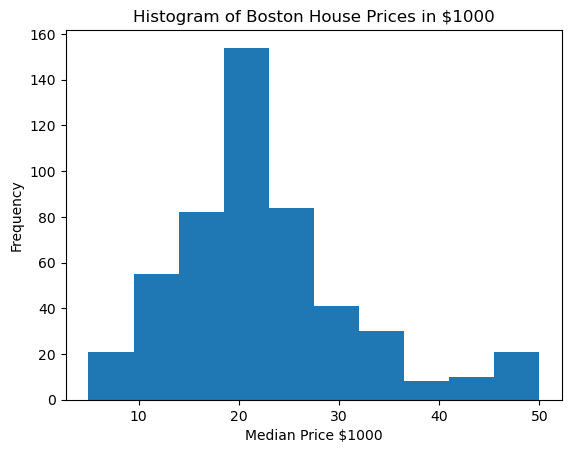

In [12]:
#histogram#
plt.hist(Ry)
plt.xlabel('Median Price $1000')
plt.ylabel('Frequency')
plt.title('Histogram of Boston House Prices in $1000')
plt.show()

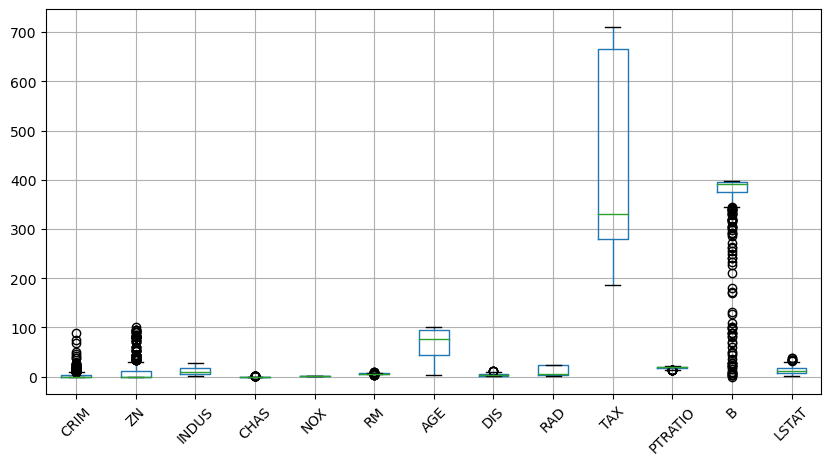

In [13]:
#boxplot for distribution#
boston.boxplot(figsize=(10,5),rot=45)
plt.show()

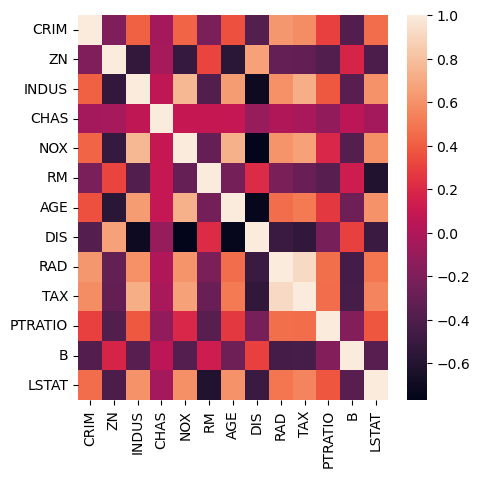

In [14]:
#heatmap for correlation#
fig, ax = plt.subplots(figsize = (5, 5)) 
Bcorr  = boston.corr() 
sn.heatmap(Bcorr) 
plt.show()

In [15]:
#convert the correlations to positive and then loop through the loops to find the highest correlation#
Bcorr = Bcorr.abs()

index = 0
while index < len(Bcorr):   
    rowIndex = Bcorr.index[index]
    sRow = Bcorr.iloc[index]
 
    sCorrs = sRow[sRow.index != rowIndex]
    sCorrs = sCorrs[sCorrs > 0.8]

    if not sCorrs.empty:
        print('highly correlated input features:', rowIndex, '&', sCorrs.index.values)
    
    index += 1


highly correlated input features: RAD & ['TAX']
highly correlated input features: TAX & ['RAD']


In [16]:
#iterating through the learning rates and getting the residuals#
dfRes = pd.DataFrame()
index = 0
while index < len(learning_rates):
    lr = learning_rates[index]
    #declaring Boosting regressor#
    rgr = Boost_Reg(RW_learner=weak_reg, no_elem=1000, lr=lr)
    #model fitting#
    rgr.fit(Rx, Ry)
    #residuals recorded#
    dfRes[str(lr)] = rgr.get_residuals()
    index += 1

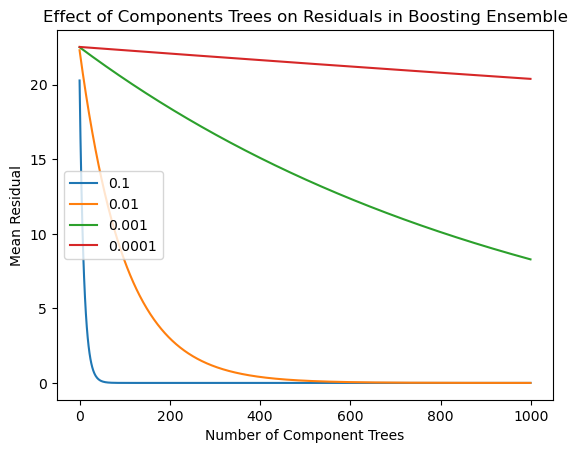

In [17]:
#plotting the residuals#
dfRes.plot()
plt.title('Effect of Components Trees on Residuals in Boosting Ensemble')
plt.xlabel('Number of Component Trees')
plt.ylabel('Mean Residual')
plt.show()

In [18]:
#scoring metrics#
Reg_scoring_metrics = {'mae': make_scorer(mean_absolute_error), 
                   'mse': make_scorer(mean_squared_error),
                   'r2': make_scorer(r2_score)}

In [19]:
#iterating throught the learning rates and calculating for 1000 elements#
lr_index = 0

while lr_index < len(learning_rates):
    lr = learning_rates[lr_index]
    #defining the model#
    Rgr = Boost_Reg(RW_learner = weak_reg, no_elem = 1000, lr=lr)
    #calculate score through cross validation#
    RegScores = cross_validate(Rgr, Rx, Ry, cv=10, scoring=Reg_scoring_metrics)
    #printing the results#
    print('Learning Rate: ', lr)
    print('Mean MAE: %.2f' % np.mean(RegScores['test_mae']))
    print('Mean MSE: %.2f' % np.mean(RegScores['test_mse']))
    print('Mean R2: %.2f' % np.mean(RegScores['test_r2']))
    print('')
    
    lr_index += 1

Learning Rate:  0.1
Mean MAE: 3.02
Mean MSE: 20.12
Mean R2: 0.48

Learning Rate:  0.01
Mean MAE: 3.16
Mean MSE: 21.63
Mean R2: 0.52

Learning Rate:  0.001
Mean MAE: 8.75
Mean MSE: 116.08
Mean R2: -1.79

Learning Rate:  0.0001
Mean MAE: 20.31
Mean MSE: 491.88
Mean R2: -14.08



In [20]:
#iterating throught the learning rates and calculating for 10000 elements#
lr_index = 0

while lr_index < len(learning_rates):
    lr = learning_rates[lr_index]
    #defining the model#
    Rgr = Boost_Reg(RW_learner = weak_reg, no_elem = 10000, lr=lr)
    #calculate score through cross validation#
    RegScores = cross_validate(Rgr, Rx, Ry, cv=10, scoring=Reg_scoring_metrics)
    #printing the results#
    print('Learning Rate: ', lr)
    print('Mean MAE: %.2f' % np.mean(RegScores['test_mae']))
    print('Mean MSE: %.2f' % np.mean(RegScores['test_mse']))
    print('Mean R2: %.2f' % np.mean(RegScores['test_r2']))
    print('')
    
    lr_index += 1

Learning Rate:  0.1
Mean MAE: 3.29
Mean MSE: 23.82
Mean R2: 0.34

Learning Rate:  0.01
Mean MAE: 3.02
Mean MSE: 20.28
Mean R2: 0.48

Learning Rate:  0.001
Mean MAE: 3.15
Mean MSE: 21.63
Mean R2: 0.52

Learning Rate:  0.0001
Mean MAE: 8.75
Mean MSE: 116.15
Mean R2: -1.79



In [21]:
#getting results for decision tree stump#
RegScores = cross_validate(weak_reg,Rx,Ry,cv=10,scoring=Reg_scoring_metrics)
print('Mean MAE: %.2f' % np.mean(RegScores['test_mae']))
print('Mean MSE: %.2f' % np.mean(RegScores['test_mse']))
print('Mean R2: %.2f' % np.mean(RegScores['test_r2']))

Mean MAE: 6.34
Mean MSE: 70.54
Mean R2: -0.85


Classification

In [22]:
#initializing the train_test_split#
x_train, x_test, y_train, y_test = train_test_split(Cx, Cy, test_size=0.2, random_state=42, stratify=Cy)

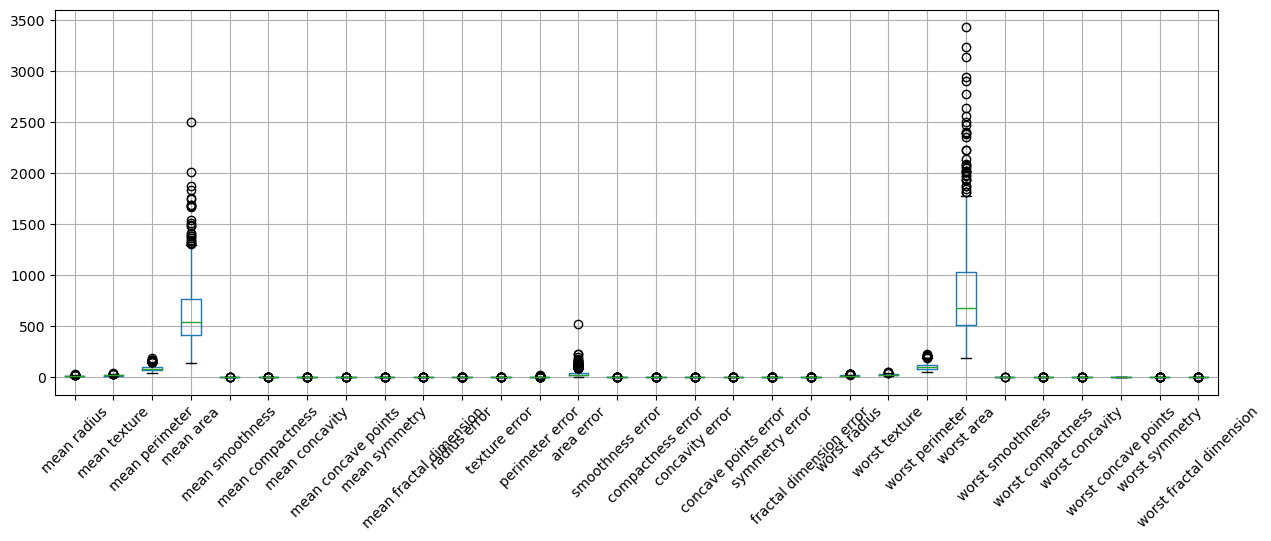

In [23]:
#boxplot for distribution#
Cancer_train = pd.DataFrame(x_train,columns=Classdata.feature_names)
Cancer_test  = pd.DataFrame(x_test,columns=Classdata.feature_names)
Cancer_train.boxplot(figsize=(15,5),rot=45)
plt.show()

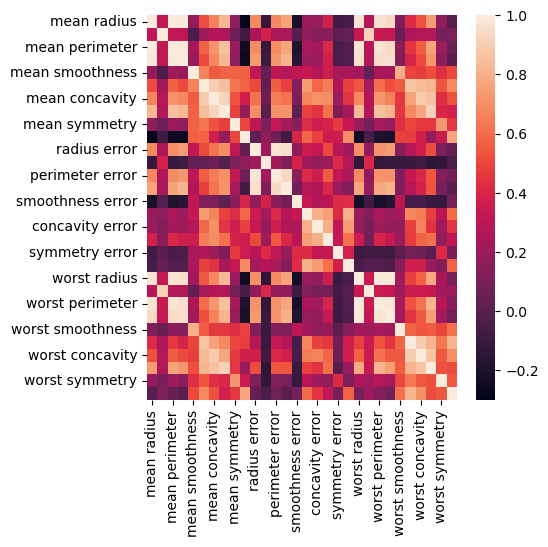

In [24]:
#heatmap for correlation#
fig, ax = plt.subplots(figsize = (5, 5)) 
Ccorr  = Cancer_train.corr() 
sn.heatmap(Ccorr) 
plt.show()

In [35]:
#we will first keep the value of no_elem as 100 for the first graph and then change it to 1000 for the next graph#
#iterate throught the learning rates and recording the F1 score#
dfC = pd.DataFrame()
lr_index = 0

while lr_index < len(learning_rates):
    lr = learning_rates[lr_index]
    #declaring boositng Classifier#
    clf = Boost_Class(CW_learner=weak_class, no_elem=1000, lr=lr, record_f1_train=True)
    #model fitting#
    clf.fit(Cx, Cy)
    #recording F1 score#
    dfC[str(lr)] = clf.get_f1s()
    
    lr_index += 1

Number of Componenets = 100


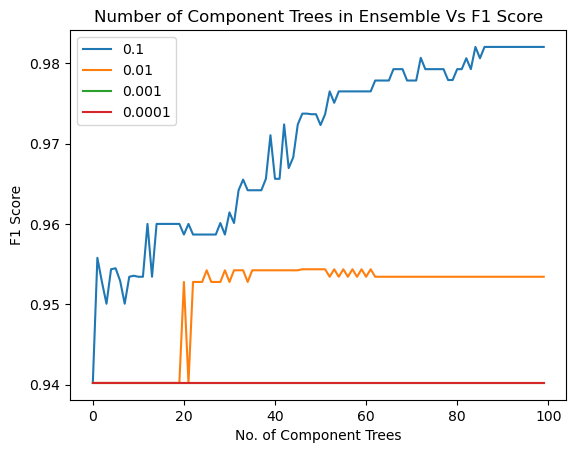

In [34]:
#plot F1 score for n = 100#
print('Number of Componenets = 100')
dfC.plot()
plt.title('Number of Component Trees in Ensemble Vs F1 Score')
plt.xlabel('No. of Component Trees')
plt.ylabel('F1 Score')
plt.show()

Number of Components = 1000


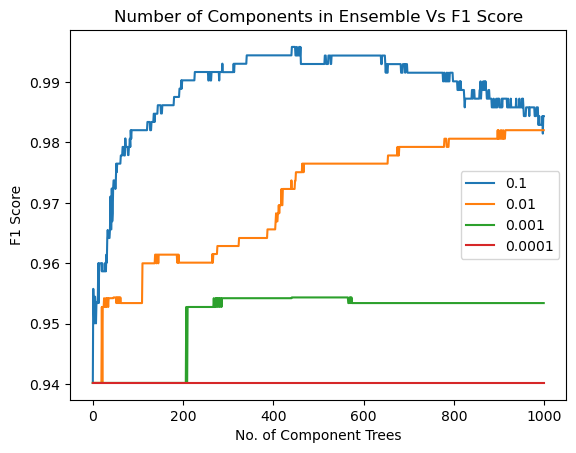

In [37]:
#plot F1 score for n = 1000#
print('Number of Components = 1000')
dfC.plot()
plt.title('Number of Components in Ensemble Vs F1 Score')
plt.xlabel('No. of Component Trees')
plt.ylabel('F1 Score')
plt.show()

In [27]:
#score metric#
Class_scoring_metrics = {'accuracy' : make_scorer(accuracy_score), 
                   'precision': make_scorer(precision_score),
                   'recall'   : make_scorer(recall_score),
                   'f1'       : make_scorer(f1_score)}

In [28]:
#iterate throught the learning rates with n=100 and evaluate the model#
lr_index = 0

while lr_index < len(learning_rates):
    lr = learning_rates[lr_index]
    #defining the model#
    clf = Boost_Class(CW_learner=weak_class, no_elem=100, lr=lr)
    #calculating the score using crossvalidation#
    ClassScores = cross_validate(clf, Cx, Cy, cv=StratifiedKFold(10), scoring=Class_scoring_metrics)
    #printing the results#
    print('Learning Rate: ', lr)
    print('Mean Accuracy: %.2f' % np.mean(ClassScores['test_accuracy']))
    print('Mean Precision: %.2f' % np.mean(ClassScores['test_precision']))
    print('Mean Recall: %.2f' % np.mean(ClassScores['test_recall']))
    print('Mean F1: %.2f' % np.mean(ClassScores['test_f1']))
    print('')
    
    lr_index += 1

Learning Rate:  0.1
Mean Accuracy: 0.96
Mean Precision: 0.95
Mean Recall: 0.98
Mean F1: 0.97

Learning Rate:  0.01
Mean Accuracy: 0.92
Mean Precision: 0.92
Mean Recall: 0.96
Mean F1: 0.94

Learning Rate:  0.001
Mean Accuracy: 0.89
Mean Precision: 0.90
Mean Recall: 0.95
Mean F1: 0.92

Learning Rate:  0.0001
Mean Accuracy: 0.89
Mean Precision: 0.90
Mean Recall: 0.95
Mean F1: 0.92



In [29]:
#iterate throught the learning rates with n=100 and evaluate the model#
lr_index = 0

while lr_index < len(learning_rates):
    lr = learning_rates[lr_index]
    #defining the model#
    clf = Boost_Class(CW_learner=weak_class, no_elem=1000, lr=lr)
    #calculating the score using crossvalidation#
    ClassScores = cross_validate(clf, Cx, Cy, cv=StratifiedKFold(10), scoring=Class_scoring_metrics)
    #printing the results#
    print('Learning Rate: ', lr)
    print('Mean Accuracy: %.2f' % np.mean(ClassScores['test_accuracy']))
    print('Mean Precision: %.2f' % np.mean(ClassScores['test_precision']))
    print('Mean Recall: %.2f' % np.mean(ClassScores['test_recall']))
    print('Mean F1: %.2f' % np.mean(ClassScores['test_f1']))
    print('')
    
    lr_index += 1

Learning Rate:  0.1
Mean Accuracy: 0.94
Mean Precision: 0.99
Mean Recall: 0.92
Mean F1: 0.95

Learning Rate:  0.01
Mean Accuracy: 0.96
Mean Precision: 0.96
Mean Recall: 0.98
Mean F1: 0.97

Learning Rate:  0.001
Mean Accuracy: 0.92
Mean Precision: 0.92
Mean Recall: 0.96
Mean F1: 0.94

Learning Rate:  0.0001
Mean Accuracy: 0.89
Mean Precision: 0.90
Mean Recall: 0.95
Mean F1: 0.92



In [30]:
#getting results for decision tree stump#
ClassScores = cross_validate(weak_class,Cx,Cy,cv=StratifiedKFold(10),scoring=Class_scoring_metrics)
print('Mean Accuracy: %.2f' % np.mean(ClassScores['test_accuracy']))
print('Mean Precision: %.2f' % np.mean(ClassScores['test_precision']))
print('Mean Recall: %.2f' % np.mean(ClassScores['test_recall']))
print('Mean F1: %.2f' % np.mean(ClassScores['test_f1']))

Mean Accuracy: 0.89
Mean Precision: 0.89
Mean Recall: 0.95
Mean F1: 0.92
